In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
data = pd.read_csv('train.csv')


0    0
1    0
2    2
3    1
4    2
Name: Group 1, dtype: int64

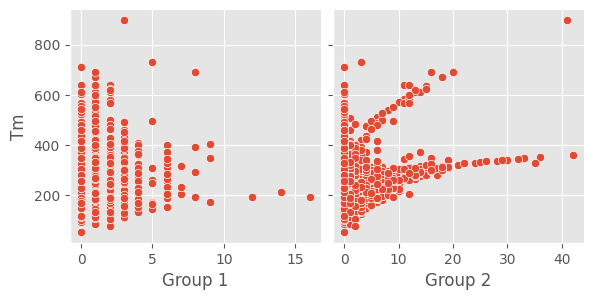

In [6]:
x = ['Group 1', 'Group 2']
y = data['Tm']
sns.pairplot(data=data, x_vars=x, y_vars='Tm', height=3, aspect=1)
